##Background
In early January 2026, headlines around Venezuela raised questions about potential changes in oil supply expectations and sanctions-related flows. This notebook tests whether the oil-exposure proxy USO shows a statistically unusual event-day jump or a response dominated by uncertainty. Using daily closes, we compute log returns, define the reaction day as the first trading day after the headline date, apply a pre-event jump threshold (±2.5σ), and track rolling volatility.

IMPORT LIBRARIES

In [1]:
import io
import math
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import statsmodels.api as sm
from IPython.display import Image, display

In [2]:
# =========================
# Market Jumps vs Noise
# Event study: Venezuela (Maduro capture) -> oil response
# Data source: Stooq (free CSV endpoint)
# Outputs: PNG charts + printed tables for interpretation
# =========================



# -------------------------
# 1) CONFIG
# -------------------------
EVENT_DATE = "2026-01-03"     # headline date
LOOKBACK_YEARS = 3           # history pulled
ESTIMATION_DAYS = 180        # days before event used for baseline model
EVENT_WINDOW = 20            # +/- trading days around event
ROLL_VOL = 10                # rolling vol window (days)
JUMP_Z = 2.5                 # jump threshold in std dev units (tune 2.0 to 3.5)

SYMBOLS = {
    "WTI (CL.F)": "cl.f",
    "Brent (CB.F)": "cb.f",
    "USO ETF (USO.US)": "uso.us",
    "VIX proxy (VI.F)": "vi.f",
    "USD index proxy (DX.F)": "dx.f",
    # Optional market proxy
    "SPY (SPY.US)": "spy.us",
}

OUTDIR = "."  # current folder

# -------------------------
# 2) DATA DOWNLOAD HELPERS
# -------------------------
def stooq_daily(symbol: str) -> pd.DataFrame:
    """
    Download daily OHLCV from Stooq via CSV endpoint.
    Returns DataFrame indexed by Date with columns: Open, High, Low, Close, Volume
    """
    url = f"https://stooq.com/q/d/l/?s={symbol}&i=d"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text))
    # Stooq columns typically: Date, Open, High, Low, Close, Volume
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").set_index("Date")
    return df

def get_close_series(symbols: dict) -> pd.DataFrame:
    closes = {}
    for name, sym in symbols.items():
        try:
            df = stooq_daily(sym)
            closes[name] = df["Close"].rename(name)
        except Exception as e:
            print(f"[WARN] Failed {name} ({sym}): {e}")
    out = pd.concat(closes.values(), axis=1).dropna(how="all")
    return out

# -------------------------
# 3) BUILD RETURNS + ALIGN EVENT DAY
# -------------------------
closes = get_close_series(SYMBOLS)

# Keep recent window
start_cut = (pd.to_datetime(EVENT_DATE) - pd.DateOffset(years=LOOKBACK_YEARS)).normalize()
closes = closes.loc[closes.index >= start_cut].copy()

# Log returns
rets = np.log(closes).diff()

event_dt = pd.to_datetime(EVENT_DATE)

# If event date not a trading day, use next available trading day in the data
trading_days = closes.dropna(how="all").index
reaction_day = trading_days[trading_days.searchsorted(event_dt)]
print(f"Headline date: {event_dt.date()} | Reaction trading day used: {reaction_day.date()}")

# -------------------------
# 4) EVENT WINDOW SLICE
# -------------------------
# Find index position
pos = trading_days.get_loc(reaction_day)
lo = max(pos - EVENT_WINDOW, 0)
hi = min(pos + EVENT_WINDOW, len(trading_days) - 1)
win_days = trading_days[lo:hi+1]

rets_win = rets.loc[win_days].copy()
closes_win = closes.loc[win_days].copy()

# Estimation window: ending 1 day before reaction day
est_end = trading_days[pos - 1] if pos - 1 >= 0 else trading_days[0]
est_start_pos = max(pos - 1 - ESTIMATION_DAYS, 0)
est_start = trading_days[est_start_pos]
rets_est = rets.loc[est_start:est_end].copy()

# -------------------------
# 5) SIMPLE JUMP FLAGS (z-score vs pre-event vol)
# -------------------------
jump_report = []
for col in rets.columns:
    s_est = rets_est[col].dropna()
    if len(s_est) < 30:
        continue
    mu = s_est.mean()
    sig = s_est.std(ddof=1)
    r0 = rets.loc[reaction_day, col] if reaction_day in rets.index else np.nan
    z0 = (r0 - mu) / sig if pd.notna(r0) and sig > 0 else np.nan
    jump_report.append([col, r0, mu, sig, z0, (abs(z0) >= JUMP_Z) if pd.notna(z0) else np.nan])

jump_df = pd.DataFrame(
    jump_report,
    columns=["Asset", "EventDayReturn(log)", "PreMean", "PreStd", "EventZ", f"Jump(|z|>={JUMP_Z})"]
).sort_values("EventZ", key=lambda x: x.abs(), ascending=False)

print("\n=== Jump diagnostic (event day vs pre-event distribution) ===")
print(jump_df.to_string(index=False))

# -------------------------
# 6) EVENT STUDY (abnormal returns via regression on USD + SPY)
# -------------------------
# Model: OilReturn_t = a + b*SPY_t + c*USD_t + e_t
# Abnormal = actual - predicted
def abnormal_returns(target_col: str, market_col="SPY (SPY.US)", usd_col="USD index proxy (DX.F)"):
    y_est = rets_est[target_col].dropna()
    X_est = rets_est[[market_col, usd_col]].dropna()
    idx = y_est.index.intersection(X_est.index)
    y_est = y_est.loc[idx]
    X_est = X_est.loc[idx]

    if len(idx) < 60:
        raise ValueError(f"Not enough estimation data for {target_col} regression.")

    X_est = sm.add_constant(X_est)
    model = sm.OLS(y_est, X_est).fit()

    X_win = rets_win[[market_col, usd_col]].copy()
    X_win = sm.add_constant(X_win, has_constant="add")
    y_win = rets_win[target_col]
    y_hat = model.predict(X_win)

    ar = (y_win - y_hat).rename("AbnormalReturn")
    car = ar.cumsum().rename("CAR")
    return model, ar, car

models = {}
ars = {}
cars = {}

targets = [c for c in rets.columns if "WTI" in c or "Brent" in c or "USO" in c]
for t in targets:
    try:
        m, ar, car = abnormal_returns(t)
        models[t] = m
        ars[t] = ar
        cars[t] = car
        print(f"\n=== Regression for {t} (estimation window) ===")
        print(m.summary().as_text())
    except Exception as e:
        print(f"[WARN] Event-study regression failed for {t}: {e}")

# -------------------------
# 7) QUICK EVENT RETURN TABLE (1d, 2d, 5d)
# -------------------------
def event_return_table(asset: str):
    # reaction day, +1, +2, +5 trading days
    p = trading_days.get_loc(reaction_day)
    horizons = [0, 1, 2, 5]
    rows = []
    for h in horizons:
        if p + h < len(trading_days):
            d = trading_days[p + h]
            r = rets.loc[d, asset]
            rows.append([asset, str(d.date()), h, r])
    return pd.DataFrame(rows, columns=["Asset", "Date", "HorizonDays", "LogReturn"])

evt_tables = []
for a in targets:
    evt_tables.append(event_return_table(a))
evt_df = pd.concat(evt_tables, axis=0)

print("\n=== Event return table (reaction day and forward horizons) ===")
print(evt_df.to_string(index=False))

# -------------------------
# 8) PLOTS
# -------------------------
def savefig(fname: str):
    path = f"{OUTDIR}/{fname}"
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.close()
    print(f"[OK] Saved: {path}")

# 8.1 Price in event window
for a in targets:
    plt.figure(figsize=(10, 4))
    plt.plot(closes_win.index, closes_win[a], linewidth=1.5)
    plt.axvline(reaction_day, linestyle="--", linewidth=1)
    plt.title(f"{a} price around event (reaction day marked)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    savefig(f"01_price_{a.replace(' ', '_').replace('(', '').replace(')', '').replace('.', '')}.png")

# 8.2 Returns + jump threshold bands (pre-event std)
for a in targets:
    s_est = rets_est[a].dropna()
    if len(s_est) < 30:
        continue
    mu, sig = s_est.mean(), s_est.std(ddof=1)

    plt.figure(figsize=(10, 4))
    plt.plot(rets_win.index, rets_win[a], linewidth=1.2)
    plt.axvline(reaction_day, linestyle="--", linewidth=1)
    plt.axhline(mu + JUMP_Z*sig, linestyle=":", linewidth=1)
    plt.axhline(mu - JUMP_Z*sig, linestyle=":", linewidth=1)
    plt.title(f"{a} log-returns (jump band = ±{JUMP_Z}σ from pre-event)")
    plt.xlabel("Date")
    plt.ylabel("Log return")
    savefig(f"02_returns_jumpband_{a.replace(' ', '_').replace('(', '').replace(')', '').replace('.', '')}.png")

# 8.3 CAR plot (if regression succeeded)
for a, car in cars.items():
    plt.figure(figsize=(10, 4))
    plt.plot(car.index, car.values, linewidth=1.5)
    plt.axvline(reaction_day, linestyle="--", linewidth=1)
    plt.title(f"{a} cumulative abnormal return (vs SPY + USD)")
    plt.xlabel("Date")
    plt.ylabel("CAR (log)")
    savefig(f"03_CAR_{a.replace(' ', '_').replace('(', '').replace(')', '').replace('.', '')}.png")

# 8.4 Rolling volatility pre/post
for a in targets:
    plt.figure(figsize=(10, 4))
    vol = rets[a].rolling(ROLL_VOL).std()
    vol_win = vol.loc[win_days]
    plt.plot(vol_win.index, vol_win.values, linewidth=1.5)
    plt.axvline(reaction_day, linestyle="--", linewidth=1)
    plt.title(f"{a} rolling {ROLL_VOL}-day volatility around event")
    plt.xlabel("Date")
    plt.ylabel("Rolling std of log-returns")
    savefig(f"04_rollvol_{a.replace(' ', '_').replace('(', '').replace(')', '').replace('.', '')}.png")

print("\nDONE. Upload the PNGs + paste the printed tables and I’ll interpret + write the LinkedIn post.")

[WARN] Failed WTI (CL.F) (cl.f): No columns to parse from file
[WARN] Failed Brent (CB.F) (cb.f): No columns to parse from file
[WARN] Failed VIX proxy (VI.F) (vi.f): No columns to parse from file
[WARN] Failed USD index proxy (DX.F) (dx.f): No columns to parse from file
Headline date: 2026-01-03 | Reaction trading day used: 2026-01-05

=== Jump diagnostic (event day vs pre-event distribution) ===
           Asset  EventDayReturn(log)  PreMean   PreStd   EventZ  Jump(|z|>=2.5)
USO ETF (USO.US)             0.018107 0.000187 0.018569 0.964985           False
    SPY (SPY.US)             0.006638 0.001308 0.007979 0.667965           False
[WARN] Event-study regression failed for USO ETF (USO.US): "['USD index proxy (DX.F)'] not in index"

=== Event return table (reaction day and forward horizons) ===
           Asset       Date  HorizonDays  LogReturn
USO ETF (USO.US) 2026-01-05            0   0.018107
USO ETF (USO.US) 2026-01-06            1  -0.024653
USO ETF (USO.US) 2026-01-07        

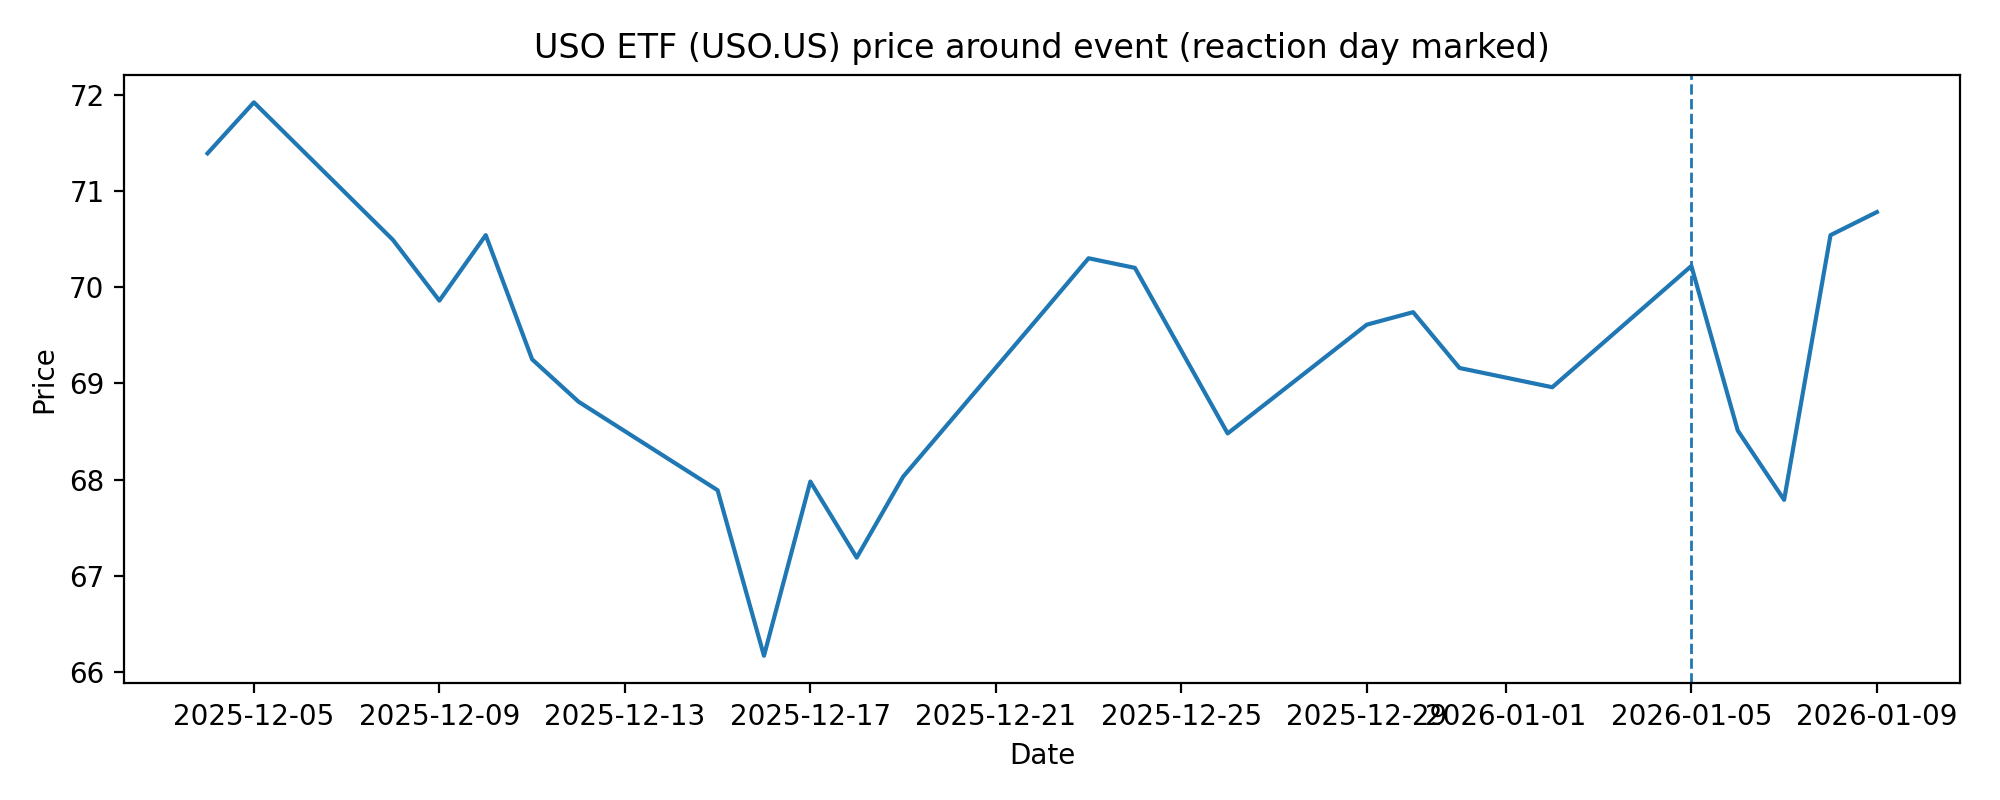

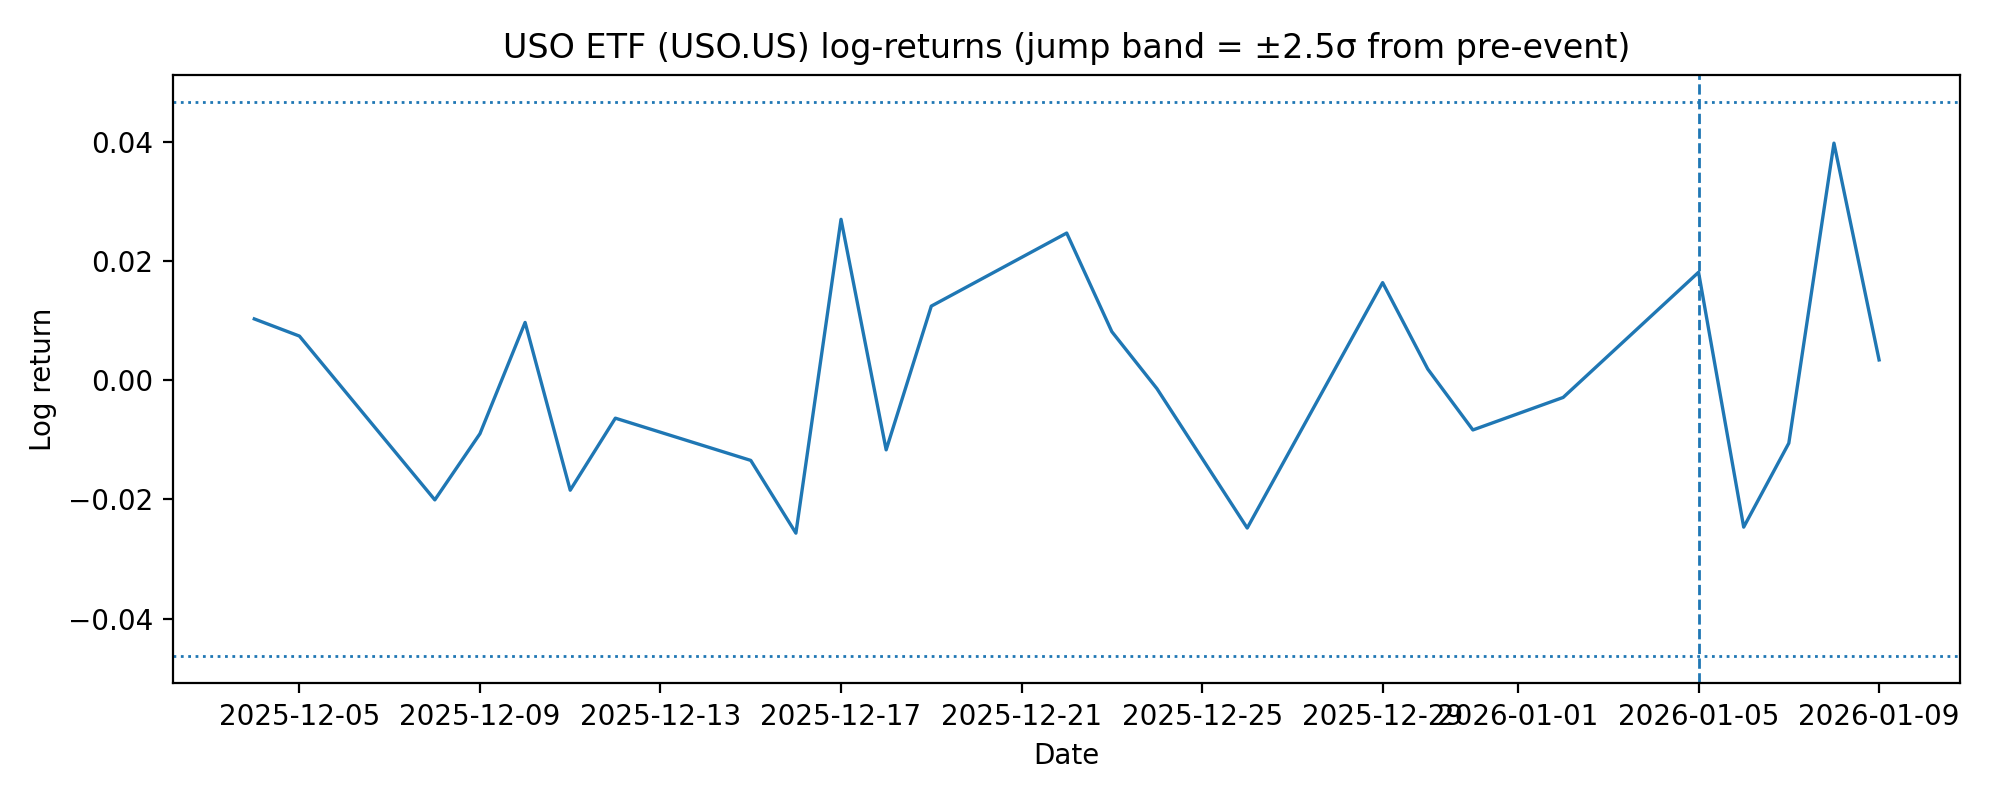

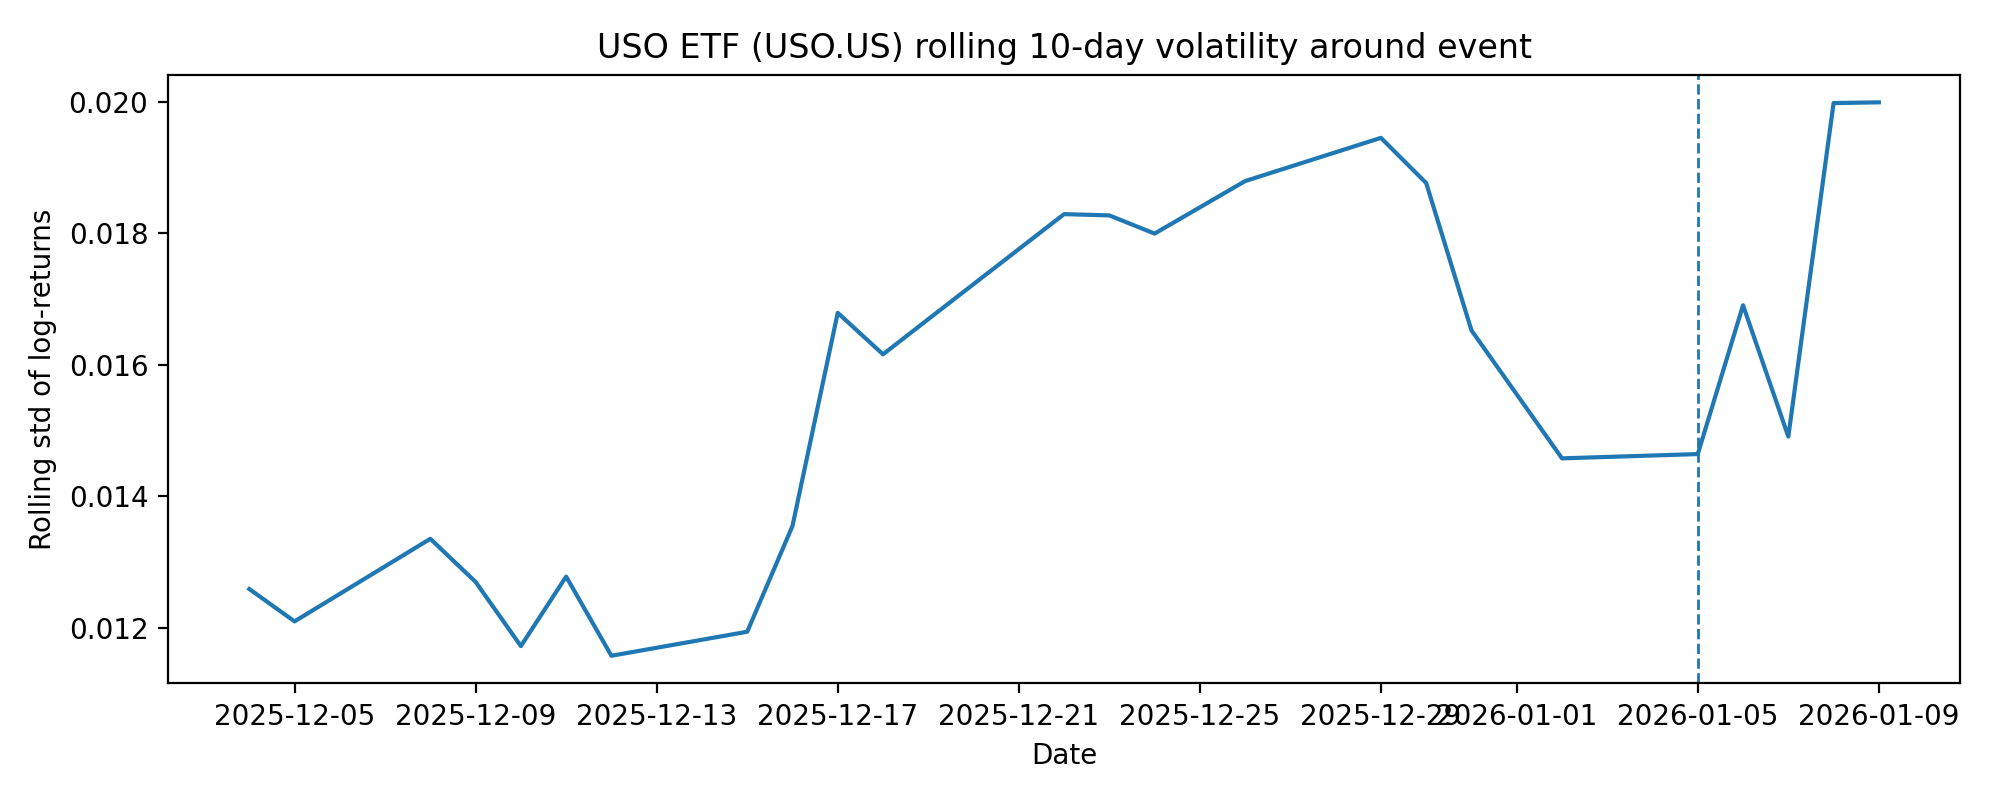

In [3]:
paths = [
    "01_price_USO_ETF_USOUS.png",
    "02_returns_jumpband_USO_ETF_USOUS.png",
    "04_rollvol_USO_ETF_USOUS.png",
]
for p in paths:
    display(Image(filename=p))